In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import re
from collections import defaultdict

In [2]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [3]:
# Modules for signal transform
from tsfresh import feature_extraction
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

In [4]:
# Consts
n_treads = 4 # used in sklearn and tsfresh
n_params = 70 # Params to remain in dataset

In [5]:
def normalize_signal(signal):
    """
    time_series
    
    Returns normalized TS: (TS - mean(TS))/std(TS)
    """
    std = np.std(signal)
    norm_signal = (signal - np.mean(signal)) / std if std else 1
    return norm_signal

In [6]:
def normalize_all_signals_in_ds(one_group_ds):
    for signal in one_group_ds.drop('t', axis=1):
        one_group_ds[signal] = normalize_signal(one_group_ds[signal])

In [7]:
# os.chdir('..')
os.getcwd()

'/home/poligon/master_degree'

In [8]:
# labels = pd.DataFrame(columns=['id', 'class', 'label'])
# labels.columns
# labels.append((pd.Series( [1, 2, 3], index=labels.columns)), ignore_index=True)
# # dfObj.append(pd.Series(['Raju', 21, 'Bangalore', 'India'], index=dfObj.columns ), ignore_index=True)

In [9]:
def append_signals_dataset(data_directory, signals_dataset = None, labels = None):
    data_dir_list = os.listdir(data_directory)
    os.chdir(data_directory)
    if labels is None:
        signal_id = 0
        labels = pd.DataFrame(columns=['id', 'class', 'label'])
    else:
        signal_id = labels.id.max() + 1
    for signal_label, directory in enumerate(data_dir_list):
        if os.path.isfile(directory) or directory[0] == '.':
                continue
        os.chdir(directory)
        for filename in os.listdir(os.curdir):
            if re.match(r'(.*csv)', filename):
                if (signals_dataset) is not None:
                    tmp_df = pd.read_csv(filename)
                    normalize_all_signals_in_ds(tmp_df)
                    tmp_df['id'] = signal_id
                    signals_dataset = signals_dataset.append(tmp_df, ignore_index=True)
                else:
                    signals_dataset = pd.read_csv(filename)
                    normalize_all_signals_in_ds(signals_dataset)
                    signals_dataset['id'] = signal_id
#                 print(signals_dataset.head(5))
                tmp_labels = pd.Series([signal_id, directory, np.int(signal_label)],
                                         index=labels.columns)
                labels = labels.append(tmp_labels, ignore_index=True)
                signal_id += 1
        os.chdir('../')
    os.chdir('../..')
    return signals_dataset, labels

Data preprocessing:
    - dropping U.1 == U
    - changing type
    - generating features

In [10]:
# os.chdir('../')
os.getcwd()

'/home/poligon/master_degree'

In [11]:
# Dataset for first gen
dataset, labels = append_signals_dataset('./data/gen_1_25')
dataset, labels = append_signals_dataset('./data/gen_3_25', dataset, labels)
# dataset, labels = append_signals_dataset('./data/gen_1_80', dataset, labels)
# Dataset for second gen
dataset_2, labels_2 = append_signals_dataset('./data/gen_1_80')
dataset_2, labels_2 = append_signals_dataset('./data/gen_2_80', dataset_2, labels_2)
dataset_2, labels_2 = append_signals_dataset('./data/gen_3_80', dataset_2, labels_2)

In [12]:
labelizer = LabelEncoder().fit(labels['class'])
def normalize_labels(labels_df):
    """
    Разметим все классы числами от 0 до количества классов
    и преобразуем новую колонку в формат чисел (float)
    """
    labels_df['label'] = labelizer.transform(labels_df['class'])
    labels_df.index = labels_df['id']
    labels_df.drop(columns=['id'])
#     unique_classes = np.unique(labels_df['class'])
#     labels_df['label'] = labels['class'].map(dict(zip(unique_classes, range(len(unique_classes)))))
#     labels_df.label = labels.label.astype('int')

In [13]:
labels.label.value_counts()

1    42
0    30
2    29
Name: label, dtype: int64

In [14]:
print("Уникальные классы в датасете:", np.unique(labels['class']))
normalize_labels(labels)
normalize_labels(labels_2)
labels.sample(5)

Уникальные классы в датасете: ['le_8' 'more_20' 'more_8']


,id,class,label
id,,,
4,4,more_20,1
88,88,more_8,2
10,10,more_20,1
1,1,more_20,1
24,24,more_8,2


In [15]:
dataset.id.nunique()

101

In [16]:
# Удалим колонки которые не несут достаточной информации (повторяют значения, не изменяются)
# или могут быть некорректны
def drop_columns(dataset):
    mod_dataset = dataset.drop(['Us', 'Pgt', 'Pij'], axis=1)
    mod_dataset.index.name = 'tmp_id'
    return mod_dataset
mod_dataset = drop_columns(dataset)
mod_dataset_2 = drop_columns(dataset_2)
# Проверим возможность склеить сигнал с метками
mod_dataset.head(5)

,t,Ug,Pg,delta,id
tmp_id,,,,,
0,0.01,0.824618,-0.053802,-1.323985,0
1,0.02,0.824618,-0.053802,-1.323985,0
2,0.03,0.824618,-0.053802,-1.323985,0
3,0.04,0.824618,-0.053802,-1.323985,0
4,0.05,0.824618,-0.053802,-1.323985,0


In [17]:
def extract_signal_features(df, labels_df, feat_selection=True, signal_list=['Ug', 'Pg', 'delta']):
    features = defaultdict()
    for param in signal_list:
#     mod_dataset[param] = mod_dataset[param].astype('float')
        features[param] = feature_extraction.extract_features\
        (df.loc[:,[param,'id','t']], column_sort='t', column_id='id', n_jobs=n_treads)
        impute(features[param])
        if feat_selection:
            features[param] = select_features(features[param], labels_df['label'], ml_task='classification', n_jobs=n_treads)
    return features

In [18]:
features = extract_signal_features(mod_dataset, labels)

Feature Extraction: 100%|██████████| 17/17 [00:33<00:00,  2.00s/it]
/home/poligon/master_degree/tsfresh/utilities/dataframe_functions.py:170: RuntimeWarning: The columns ['delta__friedrich_coefficients__m_3__r_30__coeff_0'
 'delta__friedrich_coefficients__m_3__r_30__coeff_1'
 'delta__friedrich_coefficients__m_3__r_30__coeff_2'
 'delta__friedrich_coefficients__m_3__r_30__coeff_3'
 'delta__max_langevin_fixed_point__m_3__r_30'] did not have any finite values. Filling with zeros.
  df.iloc[:, np.where(is_col_non_finite)[0]].columns.values), RuntimeWarning)


Извлечем те же признаки для проверочного датасета, который модель никогда не видела

In [19]:
features_val = extract_signal_features(mod_dataset_2, labels_2, False)

Feature Extraction: 100%|██████████| 19/19 [00:57<00:00,  3.04s/it]
/home/poligon/master_degree/tsfresh/utilities/dataframe_functions.py:170: RuntimeWarning: The columns ['delta__friedrich_coefficients__m_3__r_30__coeff_0'
 'delta__friedrich_coefficients__m_3__r_30__coeff_1'
 'delta__friedrich_coefficients__m_3__r_30__coeff_2'
 'delta__friedrich_coefficients__m_3__r_30__coeff_3'
 'delta__max_langevin_fixed_point__m_3__r_30'] did not have any finite values. Filling with zeros.
  df.iloc[:, np.where(is_col_non_finite)[0]].columns.values), RuntimeWarning)


### После обработки каждого сигнала библиотекой tsfresh извлекаем всевозможные признаки, признаки классифицированы по сигналу, из которого были получены (словарь features)
В конечном счете для каждого сигнала сформирован следующий набор данных:

In [20]:
for param in features:
    print("Для параметра", param, "получено", features[param].shape[1], "признака(ов).")

Для параметра Ug получено 636 признака(ов).
Для параметра Pg получено 635 признака(ов).
Для параметра delta получено 693 признака(ов).


In [21]:
# Пример хранящихся признаков
features['Ug'].columns.values

array(['Ug__energy_ratio_by_chunks__num_segments_10__segment_focus_3',
       'Ug__fft_coefficient__coeff_12__attr_"real"',
       'Ug__fft_coefficient__coeff_15__attr_"real"',
       'Ug__fft_coefficient__coeff_73__attr_"angle"',
       'Ug__fft_coefficient__coeff_90__attr_"angle"',
       'Ug__fft_coefficient__coeff_24__attr_"real"',
       'Ug__fft_coefficient__coeff_49__attr_"angle"',
       'Ug__fft_coefficient__coeff_50__attr_"angle"',
       'Ug__fft_coefficient__coeff_90__attr_"imag"',
       'Ug__fft_coefficient__coeff_23__attr_"real"',
       'Ug__fft_coefficient__coeff_71__attr_"angle"',
       'Ug__fft_coefficient__coeff_69__attr_"angle"',
       'Ug__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6',
       'Ug__fft_coefficient__coeff_28__attr_"angle"',
       'Ug__fft_coefficient__coeff_25__attr_"real"',
       'Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_11__w_20',
       'Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_10__w_20',
       'Ug__fft_coe

## Поиск наиболее важных признаков, которые позволят предсказывать результат переходного процесса

In [22]:
# Удаляем фичи количество признаков в которых меньше количества классов
def clear_useless_features(features, threshold=3):
    for feature in features.columns:
        if features[feature].nunique() <= threshold \
            or features[feature].isna().sum():
            features = features.drop(feature, axis=1)
    return features

In [23]:
modified_features = defaultdict()
for param in features:
    modified_features[param] = clear_useless_features(features[param],
                                                     labels.label.nunique())
    print(f"Число удаленных признаков для {param}:",
          features[param].shape[1] - modified_features[param].shape[1])

Число удаленных признаков для Ug: 30
Число удаленных признаков для Pg: 28
Число удаленных признаков для delta: 31


Поиск признаков, имеющих наибольшую корреляцию с целевой переменной sklearn (Только для регресии и неотрицательных признаков)

In [24]:
def delete_negative_features(X):
    for i in X.columns:
        if X[i].min() < 0:
            X = X.drop(i, axis=1)
    return X

In [25]:
# X = delete_negative_features(modified_features['U'])
# X_2 = 
y = labels.label
# bestfeatures = SelectKBest(score_func=chi2, k=10)
# fit = bestfeatures.fit(X, labels.label)
# dfscores = pd.DataFrame(fit.scores_)
# dfcolumns = pd.DataFrame(X.columns)
# featureScores = pd.concat([dfcolumns,dfscores],axis=1)
# featureScores.columns = ['Specs','Score']  #naming the dataframe columns
# print(featureScores.nlargest(10,'Score'))

Использование дерева для поиска фич

In [26]:
def plot_features(X, y):
#     X = modified_features['U']
#     y = labels.label
    model = ExtraTreesClassifier(n_estimators=200)
    model.fit(X,y)
#     print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
    #plot graph of feature importances for better visualization
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(20).plot(kind='barh')
    plt.show()
    return feat_importances.nlargest(75)

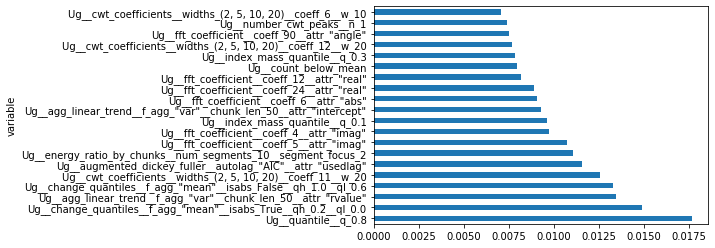

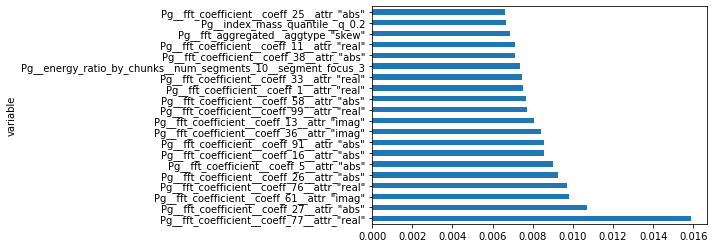

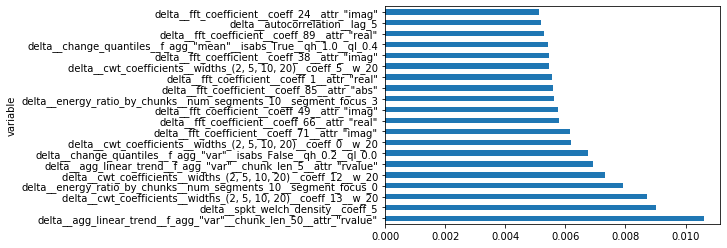

In [27]:
most_valuable_feat = dict([[feat, None] for feat in features])
for param in features:
    most_valuable_feat[param] = (plot_features(modified_features[param].astype('float32'), labels.label))

In [28]:
# Создаем датафрэйм с индексами, который будем доплнять самыми релевантными фичами
def remain_relevant_features(features):
    resulted_df = pd.DataFrame(index=features['Ug'].index)
    # Дополняем датафрэйм
    for param in features:
        for feat in features[param]:
            if feat in most_valuable_feat[param]:
#                 if most_valuable_feat[param][feat] >= 0.008:
                    resulted_df = pd.concat([resulted_df, features[param][feat]], axis=1)
    return resulted_df

In [29]:
def join_signal_features(features):
    resulted_df = pd.DataFrame(index=features['Ug'].index)
    # Дополняем датафрэйм
    for param in features:
        for feat in features[param]:
            resulted_df = pd.concat([resulted_df, features[param][feat]], axis=1)
    return resulted_df

In [30]:
# Выведем первые две строки получившегося датафрэйма
resulted_df = remain_relevant_features(features)
resulted_df.head(2)

,Ug__energy_ratio_by_chunks__num_segments_10__segment_focus_3,"Ug__fft_coefficient__coeff_12__attr_""real""","Ug__fft_coefficient__coeff_15__attr_""real""","Ug__fft_coefficient__coeff_90__attr_""angle""","Ug__fft_coefficient__coeff_24__attr_""real""","Ug__fft_coefficient__coeff_23__attr_""real""","Ug__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.6","Ug__fft_coefficient__coeff_25__attr_""real""","Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_11__w_20","Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_10__w_20",...,"delta__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.0","delta__fft_aggregated__aggtype_""kurtosis""","delta__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""rvalue""","delta__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.2","delta__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""rvalue""","delta__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""slope""","delta__agg_linear_trend__f_agg_""var""__chunk_len_5__attr_""rvalue""","delta__agg_linear_trend__f_agg_""var""__chunk_len_5__attr_""slope""",delta__energy_ratio_by_chunks__num_segments_10__segment_focus_2,"delta__fft_coefficient__coeff_1__attr_""real"""
id,,,,,,,,,,,,,,,,,,,,,
0,0.068278,0.067293,0.283316,-0.262615,0.278332,0.472285,-0.002772,0.404400,1.293201,1.075100,...,0.000090,5.224574,-0.045574,0.000014,-0.048526,-0.002035,-0.047492,-0.000002,0.114138,-5.040522
1,0.068179,-0.060615,0.193681,-1.076442,0.059987,0.431635,-0.002751,0.254238,1.245546,1.019498,...,0.000096,5.250681,-0.077398,0.000015,-0.094158,-0.004211,-0.074915,-0.000003,0.116151,-9.809813


In [31]:
print("Оставшиеся фичи:")
print(*resulted_df.columns, sep='\n')

Оставшиеся фичи:
Ug__energy_ratio_by_chunks__num_segments_10__segment_focus_3
Ug__fft_coefficient__coeff_12__attr_"real"
Ug__fft_coefficient__coeff_15__attr_"real"
Ug__fft_coefficient__coeff_90__attr_"angle"
Ug__fft_coefficient__coeff_24__attr_"real"
Ug__fft_coefficient__coeff_23__attr_"real"
Ug__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6
Ug__fft_coefficient__coeff_25__attr_"real"
Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_11__w_20
Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_10__w_20
Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_12__w_20
Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_13__w_20
Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_14__w_20
Ug__augmented_dickey_fuller__autolag_"AIC"__attr_"usedlag"
Ug__index_mass_quantile__q_0.2
Ug__index_mass_quantile__q_0.1
Ug__fft_coefficient__coeff_46__attr_"real"
Ug__fft_coefficient__coeff_27__attr_"imag"
Ug__fft_coefficient__coeff_90__attr_"real"
Ug__fft_coefficient__coeff_26__attr_"imag"
Ug__ff

Построим тепловую карту фич, взятых из предыдущего шага

In [32]:
# data = features['U'].iloc[:,0:50].join(labels.loc[:,['label']], on='id')

In [33]:
# ## get correlations of each features in dataset
# data = resulted_df.join(labels.loc[:,['id', 'label']])
# corrmat = data.corr()
# top_corr_features = corrmat.index
# plt.figure(figsize=(20,20))
# #plot heat map
# g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Постоение простейших моделей, градиентный бустинг и ансамбль решающих деревьев
Так как задача трансформировалась в задачу мультиклассификации, то воспользуемся методикой One-VS-All и построим модель для каждого отдельного класса

In [34]:
# OVA strategy
from sklearn.multiclass import OneVsRestClassifier
# OVO strategy
from sklearn.multiclass import OneVsOneClassifier
# Estimators for use in OVR (OVA)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# Estimators with built-in OVR
from sklearn.svm import LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
# Model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
# Sklearn metrics
from sklearn import metrics
# Defaultdict
from collections import defaultdict

In [35]:
X = resulted_df
y = labels.label

In [160]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [161]:
resulted_df_val = join_signal_features(features_val).reindex(columns=X.columns)
X_test, y_test = resulted_df_val, labels_2.label

## Class for model evaluating

In [192]:
class ModelEvaluator():
    strategy_list = {'ovr': OneVsRestClassifier,
                     'ovo': OneVsRestClassifier}
    metric_list = {'F1 macro':
                       lambda y_true, y_pred: metrics.f1_score(y_true, y_pred, average='macro'),
                   'F1 micro':
                       lambda y_true, y_pred: metrics.f1_score(y_true, y_pred, average='micro'),
                   'Accuracy': metrics.accuracy_score,
                   }
    
    def __init__(self, clf, strategy='ovr', n_jobs=4):
        """
        clf - classifier with fit, predict and predict_proba methods (classic)
        X_train, y_train - training dataset
        X_test, y_test - test dataset
        strategy - multiclasss Strategy OVO/OVR
        """
        if strategy.lower() not in self.strategy_list:
            raise AttributeError('Strategy must be OVR or OVO')
        self.strategy = strategy
        self.clf = self.strategy_list[strategy.lower()](clf, n_jobs)
        self.conf_matrix = None
        self.metrics = defaultdict()
    
    def count_metrics(self, y_true, y_pred):
        for metric_name, metric_func in self.metric_list.items():
            self.metrics[metric_name] = metric_func(y_true, y_pred)
    
    def evaluate(self, X_train, y_train, X_test, y_test, output=False):
        self.fit(X_train, y_train)
        y_pred = self.predict(X_test)
        self.conf_matrix = metrics.confusion_matrix(y_test, y_pred)
        self.count_metrics(y_test, y_pred)
        if output: print(*self.metrics.items(), sep='\n')
        
    def fit(self, X, y):
        self.clf.fit(X, y)
        
    def predict(self, X):
        return self.clf.predict(X)
    
    def __repr__(self):
        sep = '-' * 10 + '\n'
        res = ''
        res += f'Strategy {self.strategy} with estimator:\n'
        res += str(self.clf.estimator) + '\n'
        res += sep
        if self.conf_matrix is not None:
            res += f'Confusion matrix:\n{self.conf_matrix}\n'
            res += sep
            res += '\n'.join([' '.join(list(map(str, pair))) for pair in self.metrics.items()])
        else:
            res += 'Model is not fitted'
        return res

### AdaBoost

In [178]:
ada = AdaBoostClassifier(n_estimators=110)

In [179]:
ada_ev = ModelEvaluator(ada)

In [180]:
ada_ev.evaluate(X, y, X_test, y_test)
ada_ev

Strategy ovr with estimator:
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=110, random_state=None)
----------
Confusion matrix:
[[47  0  3]
 [ 8 15 22]
 [ 0  9 67]]
----------
F1 macro 0.7092132505175982
F1 micro 0.7543859649122807
Accuracy 0.7543859649122807

### Naive Bayes

In [181]:
gnb = GaussianNB()

In [182]:
gnb_ev = ModelEvaluator(gnb)

In [183]:
gnb_ev.evaluate(X, y, X_test, y_test)
gnb_ev

Strategy ovr with estimator:
GaussianNB(priors=None, var_smoothing=1e-09)
----------
Confusion matrix:
[[47  0  3]
 [ 0  0 45]
 [ 4  0 72]]
----------
F1 macro 0.5551289822859837
F1 micro 0.695906432748538
Accuracy 0.695906432748538

### GaussianProcess

In [184]:
gpc = GaussianProcessClassifier(multi_class = 'one_vs_one',
                                max_iter_predict=100
                               )

In [185]:
clf.fit(X, y)

OneVsRestClassifier(estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                 base_estimator=None,
                                                 learning_rate=1.0,
                                                 n_estimators=100,
                                                 random_state=None),
                    n_jobs=-1)

In [186]:
y_pred = clf.predict(X_test)

In [194]:
y_true = np.array(y_test)
print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
print("F1-macro:", metrics.f1_score(y_true, y_pred, average='macro'))
metrics.confusion_matrix(y_true, y_pred)

Accuracy: 0.7485380116959064
F1-macro: 0.7047428951620569


array([[47,  0,  3],
       [ 8, 15, 22],
       [ 0, 10, 66]])

### Ансамбль решающих деревьев
Так как задача трансформировалась в задачу мультиклассификации, то воспользуемся методикой One-VS-All и построим модель для каждого отдельного класса

In [204]:
rfc = RandomForestClassifier(n_estimators=500,
                             max_depth=5,
                             max_features='auto',
                             class_weight='balanced',
#                              bootstrap=False
                            )

In [205]:
rfc_ev = ModelEvaluator(rfc)

In [206]:
rfc_ev.evaluate(X, y, X_test, y_test)
rfc_ev

Strategy ovr with estimator:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
----------
Confusion matrix:
[[45  0  5]
 [ 0  8 37]
 [ 6 10 60]]
----------
F1 macro 0.6064048887499772
F1 micro 0.6608187134502924
Accuracy 0.6608187134502924

### Градиентный бустинг

In [207]:
gbc = GradientBoostingClassifier(learning_rate=0.1,
                                 random_state=42,
                                 n_estimators=200,
                                 min_samples_leaf=3,
                                 max_depth=3)

In [208]:
gbc_ev = ModelEvaluator(gbc)

In [209]:
gbc_ev.evaluate(X, y, X_test, y_test)
gbc_ev

Strategy ovr with estimator:
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=3, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
----------
Confusion matrix:
[[43  0  7]
 [ 8 15 22]
 [ 7 10 59]]
----------
F1 macro 0.6481266399965587
F1 micro 0.6842105263157895
Accuracy 0.6842105263157895

### CatBoost

In [210]:
from catboost import CatBoostClassifier

In [229]:
cboost_clf = CatBoostClassifier(
                                n_estimators=500,
                                max_depth=3,
                                learning_rate=0.033,
                                loss_function='MultiClass',
                                random_state=42
                                )

In [233]:
cboost_ev = ModelEvaluator(cboost_clf)
clf = cboost_clf

In [236]:
cboost_ev.evaluate(X, y, X_test, y_test)

In [237]:
cboost_ev

Strategy ovr with estimator:
----------
Confusion matrix:
[[48  0  2]
 [ 0 12 33]
 [ 1 10 65]]
----------
F1 macro 0.6888474295190714
F1 micro 0.7309941520467838
Accuracy 0.7309941520467836

In [231]:
# For searching optimal params
clf.fit(X_train, y_train, eval_set=(X_val, y_val))

0:	learn: 1.0601220	test: 1.0553037	best: 1.0553037 (0)	total: 11.1ms	remaining: 5.52s
1:	learn: 1.0240515	test: 1.0164873	best: 1.0164873 (1)	total: 26.2ms	remaining: 6.53s
2:	learn: 0.9876339	test: 0.9764973	best: 0.9764973 (2)	total: 43.4ms	remaining: 7.19s
3:	learn: 0.9554828	test: 0.9374260	best: 0.9374260 (3)	total: 58.1ms	remaining: 7.2s
4:	learn: 0.9286601	test: 0.9106005	best: 0.9106005 (4)	total: 69.5ms	remaining: 6.88s
5:	learn: 0.9006132	test: 0.8837986	best: 0.8837986 (5)	total: 81.3ms	remaining: 6.69s
6:	learn: 0.8707679	test: 0.8522774	best: 0.8522774 (6)	total: 93.8ms	remaining: 6.61s
7:	learn: 0.8487436	test: 0.8292489	best: 0.8292489 (7)	total: 106ms	remaining: 6.5s
8:	learn: 0.8235198	test: 0.8011091	best: 0.8011091 (8)	total: 120ms	remaining: 6.56s
9:	learn: 0.8016909	test: 0.7782173	best: 0.7782173 (9)	total: 136ms	remaining: 6.64s
10:	learn: 0.7741033	test: 0.7503125	best: 0.7503125 (10)	total: 148ms	remaining: 6.6s
11:	learn: 0.7518009	test: 0.7277479	best: 0.727

100:	learn: 0.1343370	test: 0.1172746	best: 0.1172746 (100)	total: 1.23s	remaining: 4.85s
101:	learn: 0.1323012	test: 0.1153087	best: 0.1153087 (101)	total: 1.24s	remaining: 4.85s
102:	learn: 0.1308301	test: 0.1139354	best: 0.1139354 (102)	total: 1.26s	remaining: 4.84s
103:	learn: 0.1289386	test: 0.1121878	best: 0.1121878 (103)	total: 1.27s	remaining: 4.84s
104:	learn: 0.1270411	test: 0.1105961	best: 0.1105961 (104)	total: 1.29s	remaining: 4.86s
105:	learn: 0.1249197	test: 0.1092582	best: 0.1092582 (105)	total: 1.3s	remaining: 4.84s
106:	learn: 0.1227520	test: 0.1072598	best: 0.1072598 (106)	total: 1.31s	remaining: 4.83s
107:	learn: 0.1212016	test: 0.1056090	best: 0.1056090 (107)	total: 1.32s	remaining: 4.81s
108:	learn: 0.1191063	test: 0.1042589	best: 0.1042589 (108)	total: 1.33s	remaining: 4.78s
109:	learn: 0.1176622	test: 0.1026747	best: 0.1026747 (109)	total: 1.34s	remaining: 4.76s
110:	learn: 0.1158545	test: 0.1009024	best: 0.1009024 (110)	total: 1.35s	remaining: 4.74s
111:	learn:

200:	learn: 0.0461900	test: 0.0440550	best: 0.0440550 (200)	total: 2.67s	remaining: 3.98s
201:	learn: 0.0458030	test: 0.0436473	best: 0.0436473 (201)	total: 2.69s	remaining: 3.97s
202:	learn: 0.0454596	test: 0.0435127	best: 0.0435127 (202)	total: 2.71s	remaining: 3.97s
203:	learn: 0.0450793	test: 0.0431297	best: 0.0431297 (203)	total: 2.72s	remaining: 3.95s
204:	learn: 0.0445956	test: 0.0429810	best: 0.0429810 (204)	total: 2.73s	remaining: 3.93s
205:	learn: 0.0443531	test: 0.0427472	best: 0.0427472 (205)	total: 2.74s	remaining: 3.91s
206:	learn: 0.0439883	test: 0.0423801	best: 0.0423801 (206)	total: 2.75s	remaining: 3.9s
207:	learn: 0.0436418	test: 0.0420280	best: 0.0420280 (207)	total: 2.76s	remaining: 3.88s
208:	learn: 0.0432903	test: 0.0416811	best: 0.0416811 (208)	total: 2.77s	remaining: 3.86s
209:	learn: 0.0429994	test: 0.0414130	best: 0.0414130 (209)	total: 2.79s	remaining: 3.85s
210:	learn: 0.0426360	test: 0.0411615	best: 0.0411615 (210)	total: 2.79s	remaining: 3.83s
211:	learn:

307:	learn: 0.0239334	test: 0.0291182	best: 0.0291182 (307)	total: 3.88s	remaining: 2.42s
308:	learn: 0.0238178	test: 0.0290917	best: 0.0290917 (308)	total: 3.89s	remaining: 2.41s
309:	learn: 0.0236968	test: 0.0290077	best: 0.0290077 (309)	total: 3.9s	remaining: 2.39s
310:	learn: 0.0235809	test: 0.0289818	best: 0.0289818 (310)	total: 3.92s	remaining: 2.38s
311:	learn: 0.0234724	test: 0.0289470	best: 0.0289470 (311)	total: 3.93s	remaining: 2.37s
312:	learn: 0.0233847	test: 0.0289608	best: 0.0289470 (311)	total: 3.94s	remaining: 2.35s
313:	learn: 0.0232778	test: 0.0289319	best: 0.0289319 (313)	total: 3.95s	remaining: 2.34s
314:	learn: 0.0231674	test: 0.0289146	best: 0.0289146 (314)	total: 3.96s	remaining: 2.33s
315:	learn: 0.0230551	test: 0.0288921	best: 0.0288921 (315)	total: 3.97s	remaining: 2.31s
316:	learn: 0.0229618	test: 0.0288593	best: 0.0288593 (316)	total: 3.98s	remaining: 2.3s
317:	learn: 0.0228510	test: 0.0288390	best: 0.0288390 (317)	total: 3.99s	remaining: 2.29s
318:	learn: 

402:	learn: 0.0165382	test: 0.0268044	best: 0.0267217 (397)	total: 4.9s	remaining: 1.18s
403:	learn: 0.0164928	test: 0.0268330	best: 0.0267217 (397)	total: 4.92s	remaining: 1.17s
404:	learn: 0.0164325	test: 0.0267263	best: 0.0267217 (397)	total: 4.93s	remaining: 1.16s
405:	learn: 0.0163781	test: 0.0267835	best: 0.0267217 (397)	total: 4.94s	remaining: 1.14s
406:	learn: 0.0163157	test: 0.0267774	best: 0.0267217 (397)	total: 4.95s	remaining: 1.13s
407:	learn: 0.0162653	test: 0.0266582	best: 0.0266582 (407)	total: 4.96s	remaining: 1.12s
408:	learn: 0.0162110	test: 0.0266535	best: 0.0266535 (408)	total: 4.97s	remaining: 1.1s
409:	learn: 0.0161767	test: 0.0266667	best: 0.0266535 (408)	total: 4.98s	remaining: 1.09s
410:	learn: 0.0161195	test: 0.0266724	best: 0.0266535 (408)	total: 4.99s	remaining: 1.08s
411:	learn: 0.0160856	test: 0.0266858	best: 0.0266535 (408)	total: 5s	remaining: 1.07s
412:	learn: 0.0160140	test: 0.0266833	best: 0.0266535 (408)	total: 5.01s	remaining: 1.06s
413:	learn: 0.0

494:	learn: 0.0126632	test: 0.0265511	best: 0.0264098 (480)	total: 5.9s	remaining: 59.6ms
495:	learn: 0.0126284	test: 0.0265485	best: 0.0264098 (480)	total: 5.92s	remaining: 47.7ms
496:	learn: 0.0125939	test: 0.0265584	best: 0.0264098 (480)	total: 5.93s	remaining: 35.8ms
497:	learn: 0.0125605	test: 0.0265644	best: 0.0264098 (480)	total: 5.94s	remaining: 23.9ms
498:	learn: 0.0125309	test: 0.0265643	best: 0.0264098 (480)	total: 5.95s	remaining: 11.9ms
499:	learn: 0.0124981	test: 0.0265708	best: 0.0264098 (480)	total: 5.96s	remaining: 0us

bestTest = 0.02640979624
bestIteration = 480

Shrink model to first 481 iterations.


In [232]:
y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
metrics.confusion_matrix(y_true, clf.predict(X_test))

Accuracy: 0.7076023391812866


array([[47,  0,  3],
       [ 0, 14, 31],
       [ 6, 10, 60]])

In [ ]:
predicted_labels = labelizer.inverse_transform(clf.predict(X_val)).reshape(-1,1)
predicted_df = pd.DataFrame(np.concatenate([predicted_labels, clf.predict_proba(X_val)], axis=1),
                            index=labels_2.index,
                            columns=['predicted_class'] + list(labelizer.classes_),
                           )
pd.concat(
          [labels_2,
           predicted_df
          ],
          axis=1).sample(10)

In [ ]:
clf.predict(X_val).reshape(1,-1)

In [ ]:
y_val.values

In [ ]:
labelizer.classes_[1]

Гит комит

In [ ]:
# !git status
# !git add .
# !git commit -m "Added another generator"
